Download data from bull dozers competition from kaggle to proceed

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [5]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

/home/venkat/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [6]:
df_raw.shape

(401125, 65)

In [7]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [8]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

##confidence based on tree interval

In [9]:
set_rf_samples(50000)

In [10]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20660719730710228, 0.25054068455528583, 0.910787498125624, 0.8879002888805376, 0.8935970145865263]


In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.57 s, sys: 35.9 ms, total: 1.61 s
Wall time: 1.62 s


(9.262614966515926, 0.23453660857944597)

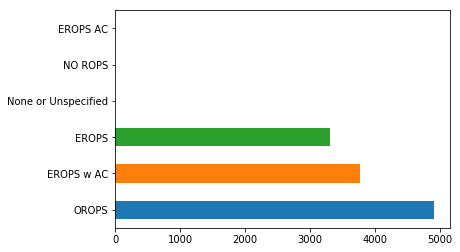

In [12]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh()


In [13]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ=x[flds].groupby('Enclosure',as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.841989,0.279531
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.579882,0.265902
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684762,0.221822


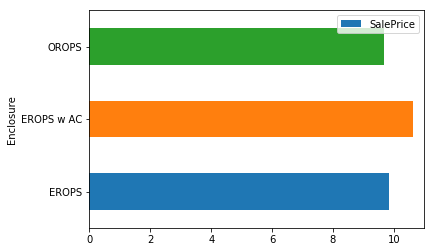

In [14]:
enc_summ=enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure','SalePrice','barh',xlim=(0,11));

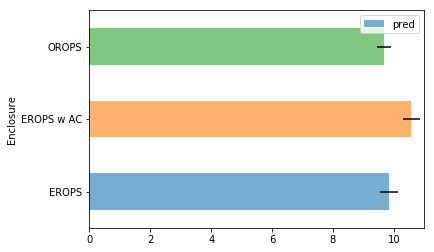

In [15]:
enc_summ.plot('Enclosure','pred','barh',xerr='pred_std',xlim=(0,11),alpha=0.6);

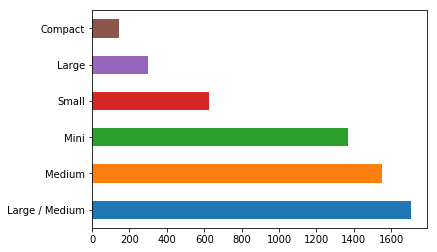

In [16]:
raw_valid.ProductSize.value_counts().plot.barh()

In [17]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.863396,0.344005
Large,10.470589,10.377635,0.357952
Large / Medium,10.691871,10.640824,0.299176
Medium,10.681511,10.620530,0.287071
Mini,9.535147,9.570816,0.262958
Small,10.324448,10.321170,0.309741


In [18]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.034877
Large             0.034493
Small             0.030010
Large / Medium    0.028116
Mini              0.027475
Medium            0.027030
dtype: float64

##Feature Importance

In [19]:
df=pd.DataFrame({'col_name':df_trn.columns,'imp':m.feature_importances_}).sort_values('imp',ascending=False)
df.iloc[:10,]

,col_name,imp
5,YearMade,0.176802
37,Coupler_System,0.114887
13,ProductSize,0.090776
14,fiProductClassDesc,0.085887
19,Enclosure,0.055626
63,saleElapsed,0.050556
2,ModelID,0.049359
10,fiSecondaryDesc,0.043816
38,Grouser_Tracks,0.041643
39,Hydraulics_Flow,0.032819


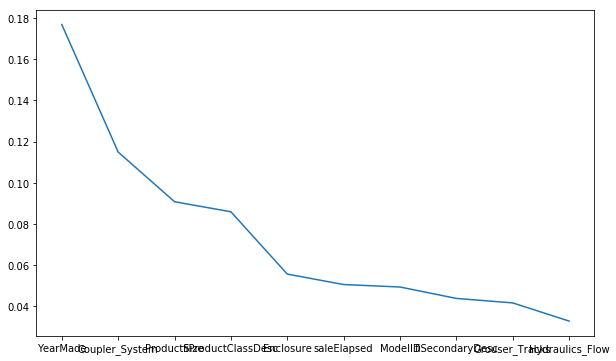

In [20]:
plt.figure(figsize=(10,6))
plt.plot(df.col_name[:10],df.imp[:10])

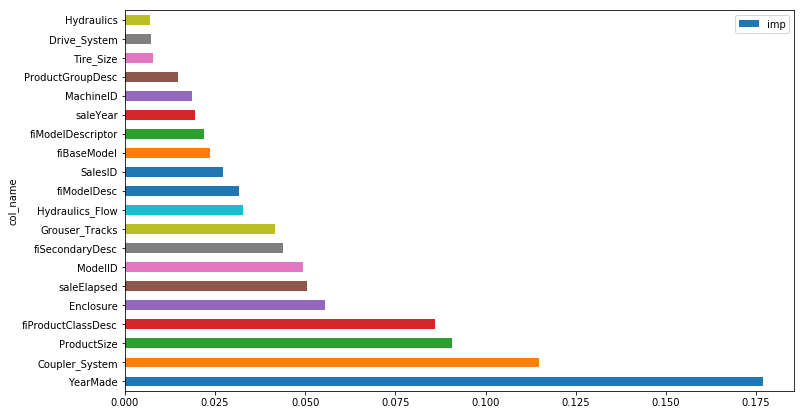

In [21]:
df[:20].plot('col_name','imp',kind='barh',figsize=(12,7))

In [22]:
to_keep=df[df.imp>0.005].col_name
len(to_keep)

24

In [25]:
df_keep=df_trn[to_keep].copy()
X_train,X_valid=split_vals(df_keep,n_trn)

In [29]:
m=RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.206666947166123, 0.24558091470784835, 0.9107358909672285, 0.892294669118932, 0.894387069902134]


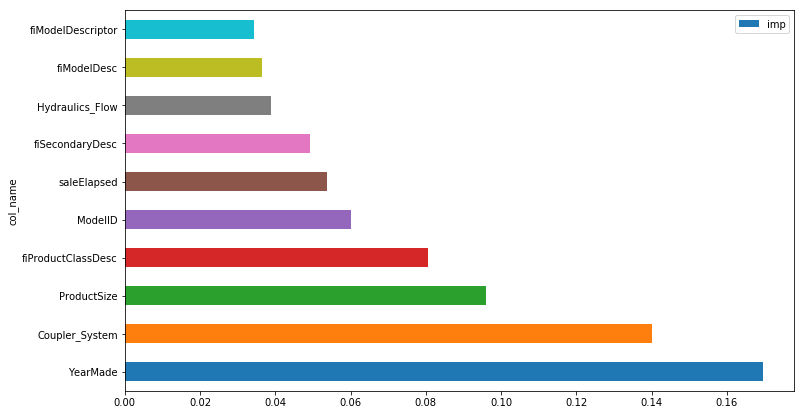

In [32]:
df=pd.DataFrame({'col_name':df_keep.columns,'imp':m.feature_importances_}).sort_values('imp',ascending=False)
df[:10].plot('col_name','imp',kind='barh',figsize=(12,7))

In [33]:
df_trn2,y_trn,nas=proc_df(df_raw,'SalePrice',max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m=RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.6,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.20677206304870557, 0.25289447512985147, 0.9106450640404855, 0.88578407608187, 0.8930527576569498]


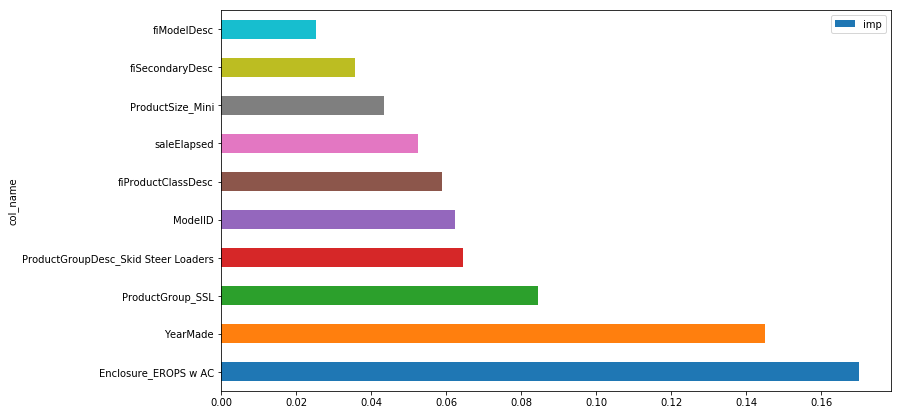

In [36]:
df=pd.DataFrame({'col_name':df_trn2.columns,'imp':m.feature_importances_}).sort_values('imp',ascending=False)
df[:10].plot('col_name','imp',kind='barh',figsize=(12,7))

#Removing Redundant features

In [38]:
from scipy.cluster import hierarchy as hc

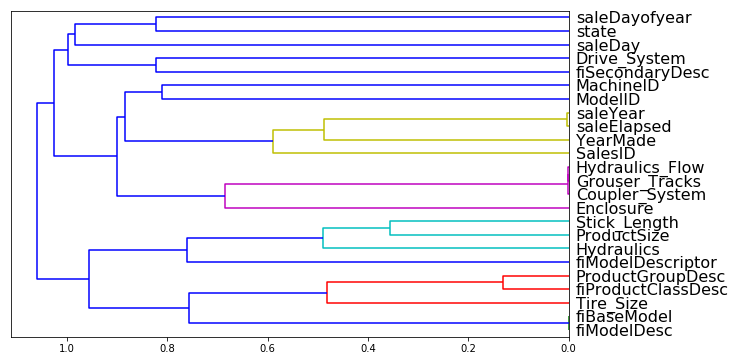

In [43]:
corr=np.round(scipy.stats.spearmanr(df_keep).correlation,4)
corr_condensed=hc.distance.squareform(1-corr)
z=hc.linkage(corr_condensed,method='average')
fig=plt.figure(figsize=(10,6))
dendrogram=hc.dendrogram(z,labels=df_keep.columns,orientation='left',leaf_font_size=16)
plt.show()

In [45]:
def get_oob(df):
    m=RandomForestRegressor(n_estimators=40,min_samples_leaf=5,max_features=0.6,n_jobs=-1,oob_score=True)
    x,_=split_vals(df,n_trn)
    m.fit(x,y_train)
    return m.oob_score_

In [47]:
get_oob(df_keep)

0.8909932795055138

In [48]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c,get_oob(df_keep.drop(c,axis=1)))

saleYear 0.890169267869931
saleElapsed 0.8876223668263655
fiModelDesc 0.8899694685731093
fiBaseModel 0.889780552455961
Grouser_Tracks 0.8911345552436454
Coupler_System 0.890843675960589


In [50]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop,axis=1))

0.8896632173575754

In [51]:
df_keep.drop(to_drop,axis=1,inplace=True)
X_train,X_valid=split_vals(df_keep,n_trn)

In [52]:
np.save('tmp/keep_cols.npy',np.array(df_keep.columns))

In [55]:
keep_cols=np.load('tmp/keep_cols.npy')
df_keep=df_trn[keep_cols]

In [57]:
reset_rf_samples()

In [58]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12549620978942636, 0.22688698905604474, 0.9670848343428302, 0.9080679049244905, 0.9087430369922503]


#partial dependence

In [61]:
from pdpbox import pdp
from plotnine import *

In [62]:
set_rf_samples(50000)

In [63]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

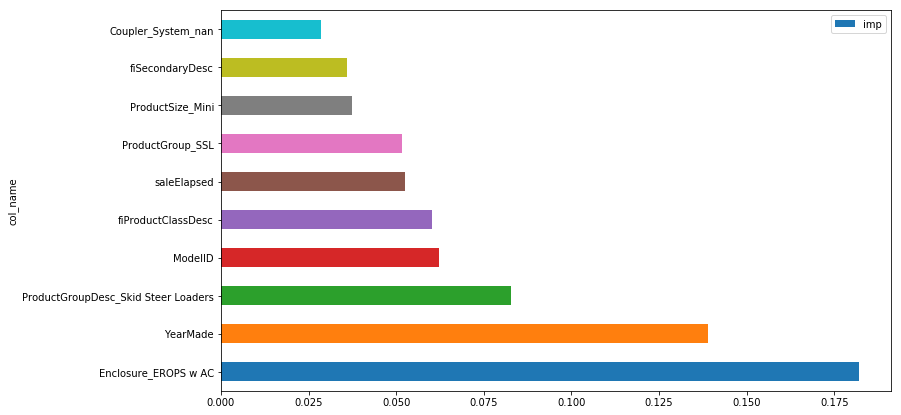

In [64]:
df=pd.DataFrame({'col_name':df_trn2.columns,'imp':m.feature_importances_}).sort_values('imp',ascending=False)
df[:10].plot('col_name','imp',kind='barh',figsize=(12,7))

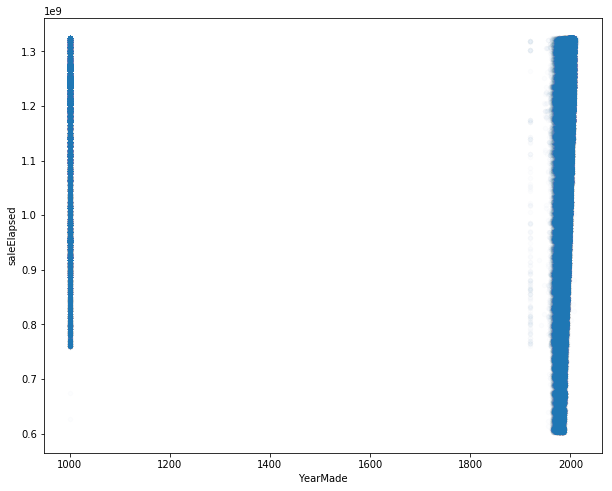

In [66]:
df_raw.plot('YearMade','saleElapsed','scatter',alpha=0.01,figsize=(10,8))

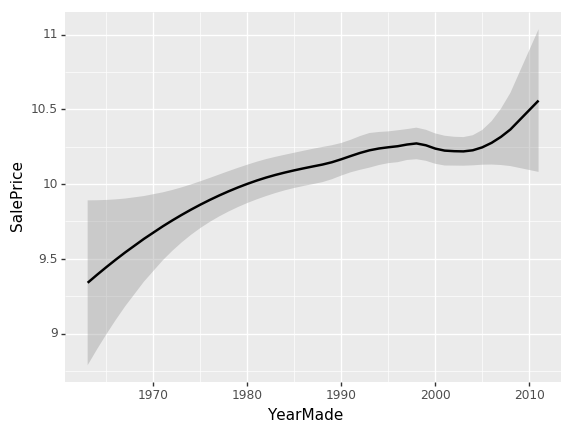

<ggplot: (-9223363305037399941)>

In [91]:
x_all=get_sample(df_raw[df_raw.YearMade>1930],500)
ggplot(x_all,aes('YearMade','SalePrice'))+stat_smooth(se=True,method='loess')

In [87]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [116]:
def plot_pdp(feat,clusters=None,feat_name=None):
    feat_name=feat_name or feat
    p=pdp.pdp_isolate(m,x,x.columns,feat)
    return pdp.pdp_plot(p,feat_name,plot_lines=True,
                       cluster=clusters is not None,n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f108de4a518>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f108ddfcb38>})

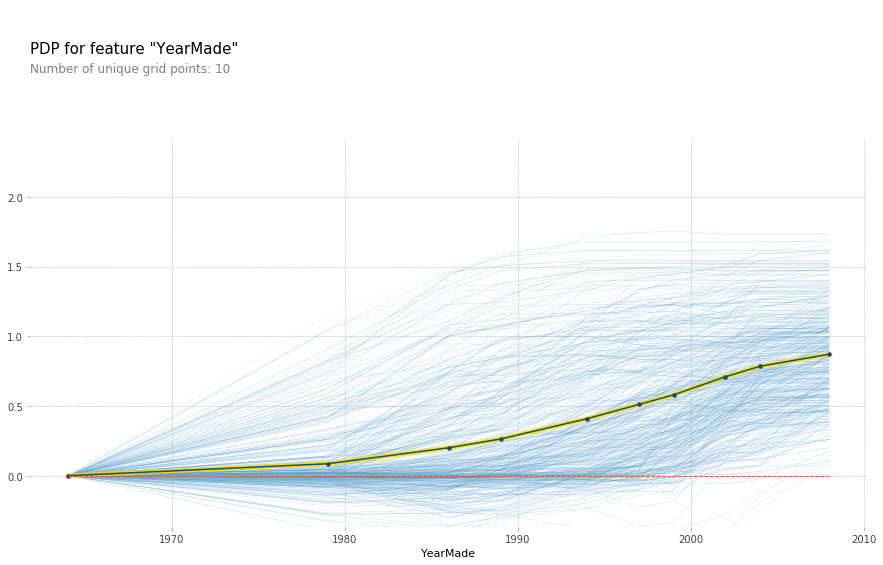

In [117]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f10880afb38>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f108816bf98>})

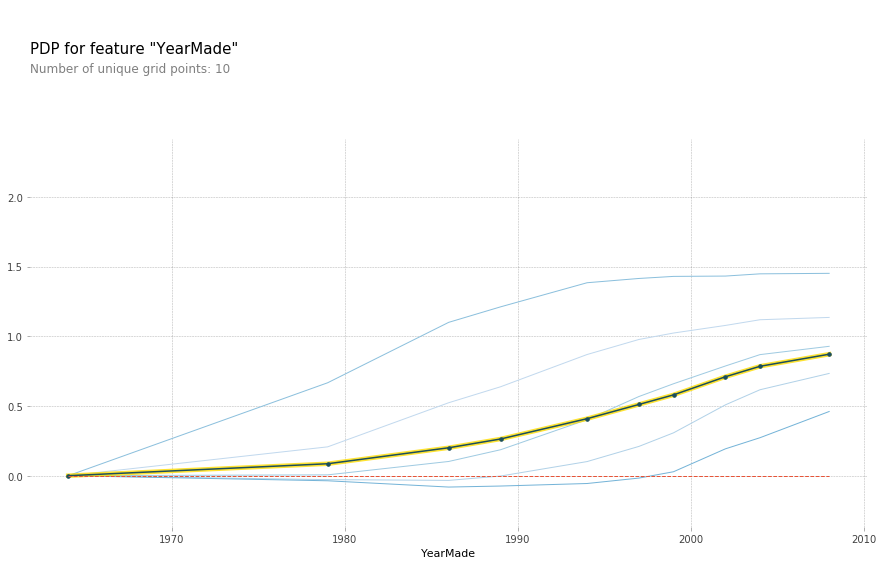

In [118]:
plot_pdp('YearMade',clusters=5)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f108dc33588>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f108db05240>})

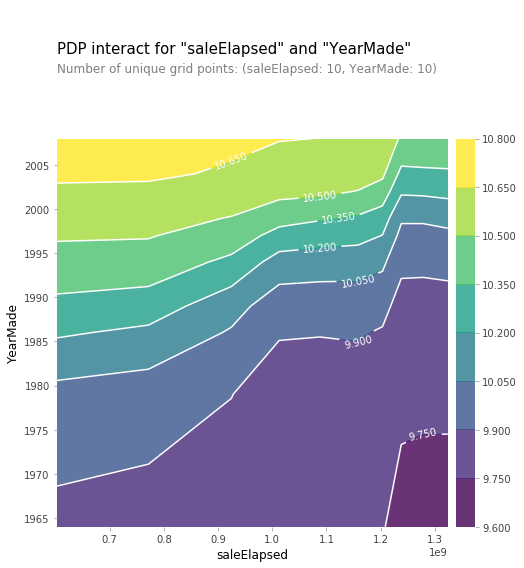

In [122]:
feats=['saleElapsed','YearMade']
p=pdp.pdp_interact(m,x,x.columns,feats)
pdp.pdp_interact_plot(p,feats)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f108d8ec7f0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f108d8eed68>})

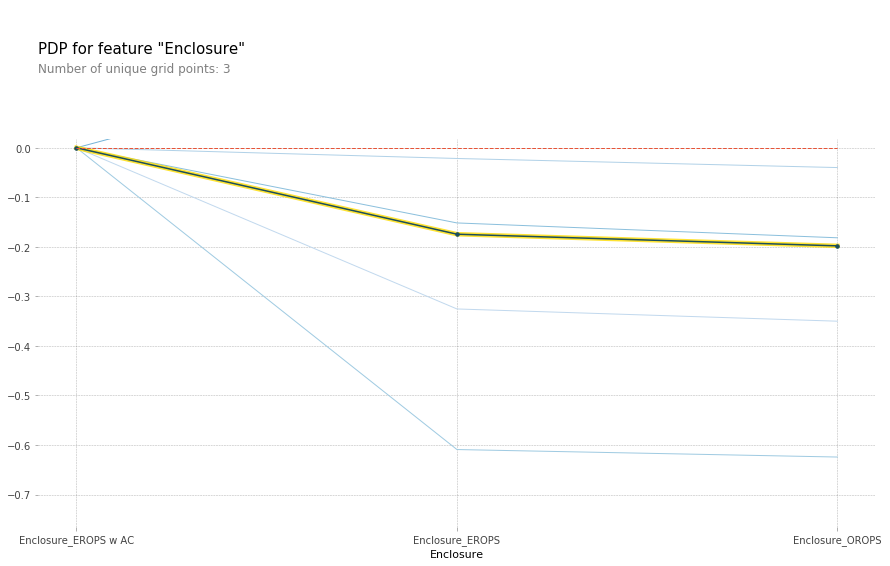

In [125]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'],5,'Enclosure')

In [126]:
df_raw.YearMade[df_raw.YearMade<1950]=1950
df_keep['age']=df_raw['age']=df_raw.saleYear-df_raw.YearMade

In [127]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

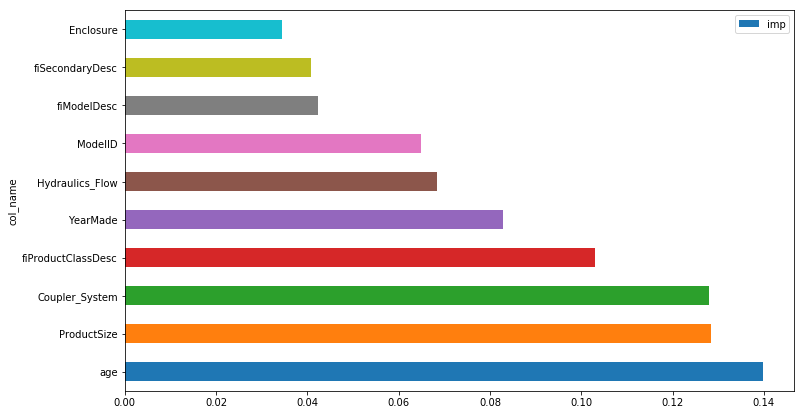

In [129]:
df=pd.DataFrame({'col_name':X_train.columns,'imp':m.feature_importances_}).sort_values('imp',ascending=False)
df[:10].plot('col_name','imp',kind='barh',figsize=(12,7))

#Tree Interpreter

In [131]:
from treeinterpreter import treeinterpreter as ti

In [132]:
df_train,df_valid=split_vals(df_raw[df_keep.columns],n_trn)

In [144]:
row=X_valid.values[None,0];row

array([[      1999,          0,          5,         17,          1, 1284595200,        665,          0,
                 0,       3232,    4364751,          0,    2300944,          4,          0,          0,
                12,         16,         35,        259,         29,         11]])

In [145]:
prediction,bias,contributions=ti.predict(m,row)

In [147]:
prediction,bias

(array([9.26022]), array([10.10606]))

In [148]:
idxs=np.argsort(contributions[0])

In [154]:
[o for o in zip(df_keep.columns[idxs],df_valid.iloc[0][idxs],contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5997833979707085),
 ('age', 11, -0.16913096345474954),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11321947798630227),
 ('fiModelDesc', 'KX1212', -0.07732891052314872),
 ('fiSecondaryDesc', nan, -0.05956892838026562),
 ('SalesID', 4364751, -0.03971395069142743),
 ('Tire_Size', nan, -0.023718899277147144),
 ('Enclosure', 'EROPS', -0.021564956040035322),
 ('state', 'Ohio', -0.01777288843482152),
 ('fiModelDescriptor', nan, -0.014210477583150772),
 ('MachineID', 2300944, -0.013612895616232957),
 ('saleElapsed', 1284595200, -0.012722238171419509),
 ('saleDayofyear', 259, -0.003781171432873842),
 ('saleDay', 16, -0.0032782977965472248),
 ('Stick_Length', 'None or Unspecified', 0.0026110726637129213),
 ('ProductGroupDesc', 'Track Excavators', 0.005402538167199156),
 ('Drive_System', nan, 0.008932215736497407),
 ('Hydraulics', 'Standard', 0.024170382730483685),
 ('Hydraulics_Flow', nan, 0.03165161413618236),
 ('Coupler_Syst

In [162]:
contributions[0].sum()

-0.845837093199442

#Extrapolation

In [168]:
df_ext=df_keep.copy()
df_ext['is_valid']=1
df_ext.is_valid[:n_trn]=0
x,y,nas=proc_df(df_ext,'is_valid')

In [169]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999950140230601

In [171]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.858118
5,saleElapsed,0.088407
12,MachineID,0.042004
19,saleDayofyear,0.004795
9,fiModelDesc,0.002484
6,ModelID,0.001117
0,YearMade,0.000739
8,Hydraulics_Flow,0.000591
4,Enclosure,0.000567
1,Coupler_System,0.000395


In [172]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [173]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [174]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [175]:
x.drop(feats, axis=1, inplace=True)

In [176]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.979235899033967

In [177]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.238389
0,YearMade,0.185884
16,saleDayofyear,0.155357
5,ModelID,0.077661
8,fiModelDesc,0.063048
14,saleDay,0.057865
15,state,0.053601
3,fiProductClassDesc,0.032171
6,fiSecondaryDesc,0.024670
4,Enclosure,0.020805


In [178]:
set_rf_samples(50000)

In [179]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [180]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2082588361727125, 0.24958226972182276, 0.9093554493868892, 0.8887562977973538, 0.8926528588075068]


In [182]:
for f in feats:
    df_subs=df_keep.drop(f,axis=1)
    X_train,X_valid=split_vals(df_subs,n_trn)
    m=RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=-1,oob_score=True)
    m.fit(X_train,y_train)
    print(f)
    print_score(m)

SalesID
[0.20915176423830076, 0.2456704983798725, 0.9085764900745282, 0.8922160767016283, 0.8924042979263375]
saleElapsed
[0.21449886650942687, 0.2550067350261662, 0.9038421312127636, 0.8838681684159313, 0.8867034999250428]
MachineID
[0.20739583841288795, 0.245911521211104, 0.9101051315250849, 0.8920044832869871, 0.8943416887376345]
age
[0.20961697912795135, 0.24779653890533854, 0.9081693323382232, 0.8903424733249665, 0.8915675580902259]
YearMade
[0.20860726488996278, 0.251020900577666, 0.9090518888246594, 0.8874701498158596, 0.8925766892951315]
saleDayofyear
[0.20906025073577228, 0.24518539132877593, 0.9086564765405888, 0.8926413220459758, 0.892624254573058]


In [183]:
reset_rf_samples()

In [184]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13828863573936628, 0.2180749725155679, 0.9600324239064596, 0.9150702928037838, 0.9091290620776741]


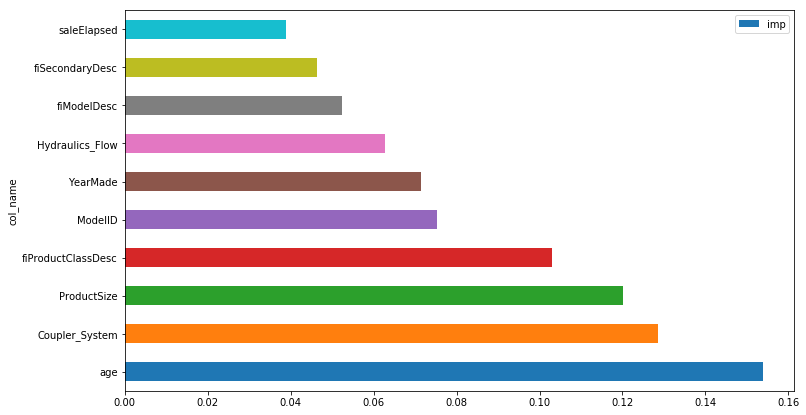

In [185]:
df=pd.DataFrame({'col_name':X_train.columns,'imp':m.feature_importances_}).sort_values('imp',ascending=False)
df[:10].plot('col_name','imp',kind='barh',figsize=(12,7))

In [186]:
np.save('tmp/subs_cols.npy',np.array(df_subs.columns))

###our final model

In [189]:
m=RandomForestRegressor(n_estimators=160,max_features=0.5,n_jobs=-1,oob_score=True)
%time m.fit(X_train,y_train)
print_score(m)

CPU times: user 3min 7s, sys: 4.88 s, total: 3min 12s
Wall time: 1min 2s
[0.0799796073811422, 0.21135728436960352, 0.9866311711996203, 0.9202221341025844, 0.9145254751581011]
